In [23]:
from sklearn.ensemble import (RandomForestRegressor, IsolationForest)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import numpy as np
import pandas as pd
import ml_helper as ml
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.linear_model import (ElasticNet, Ridge, Lasso)
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, KFold)
import time
import AveragedModels as av
import numpy as np
import xgboost as xgb
import AveragedModels as av
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import ml_helper as mlh
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')


In [3]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))


The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [4]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


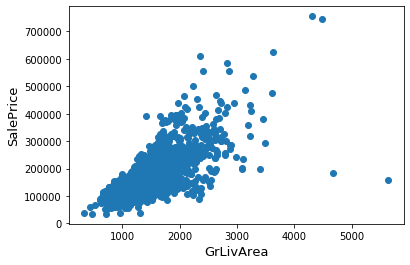

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [8]:
def scatterPlot(df, X, Y, font=13):
    fig, ax = plt.subplots()
    ax.scatter(x = df[X], y = df[Y])
    plt.ylabel(Y, fontsize=13)
    plt.xlabel(X, fontsize=13)
    plt.show()
    
def crossValidateModel(model, X, y, name="<unknown>", threads = -1):
    start = time.time()
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train)
    scores = cross_val_score(model, X, y, scoring = "neg_mean_absolute_error", n_jobs = threads, verbose = 4, cv = kf)
    end = time.time()
    elapsed_time = end - start
    print("model {0} cross_val_score took {1} seconds".format(name, elapsed_time))
    displayScores(-scores)
    
def displayScores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("standard deviation:", scores.std())

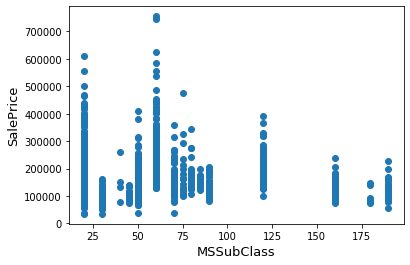

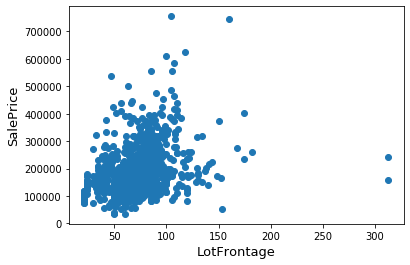

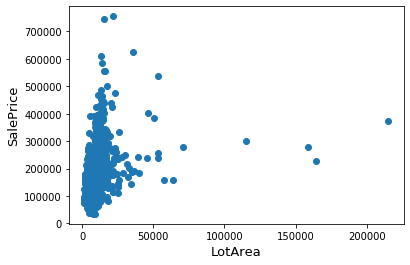

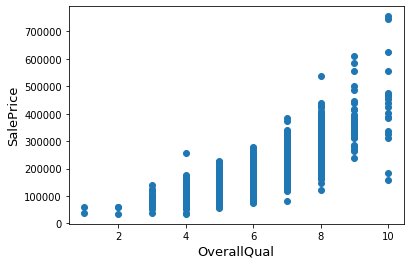

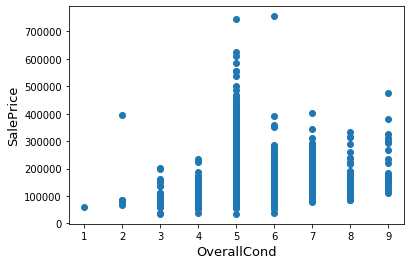

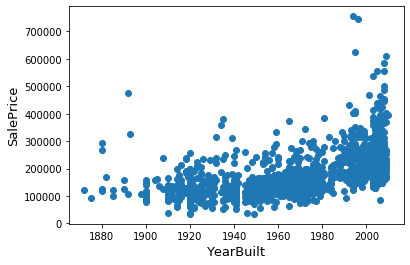

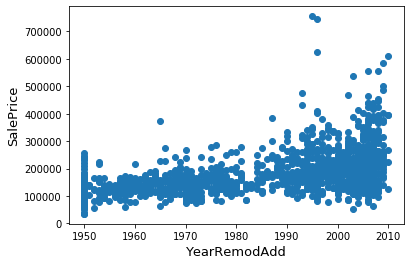

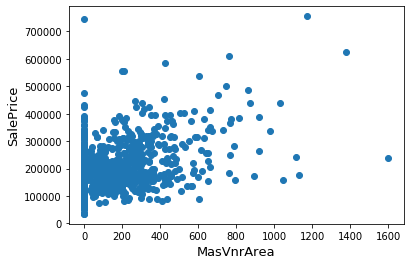

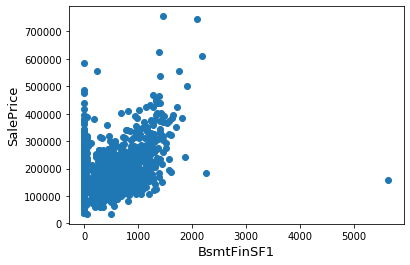

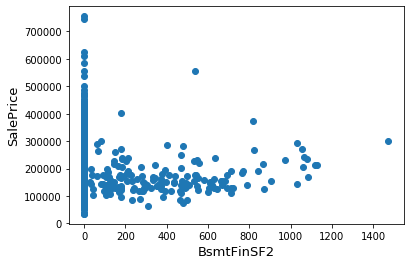

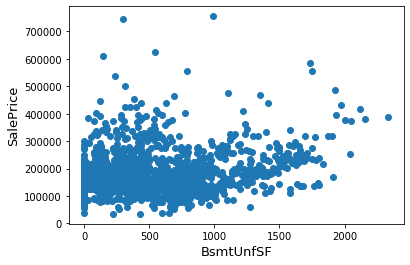

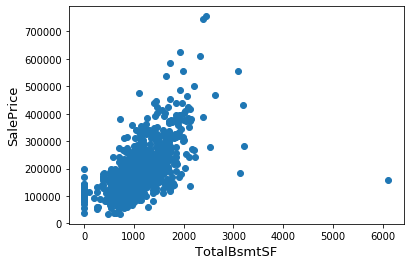

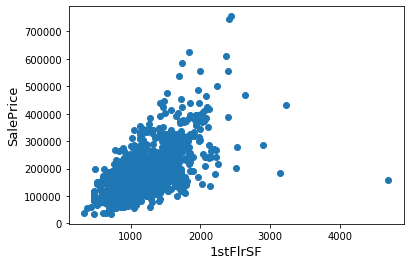

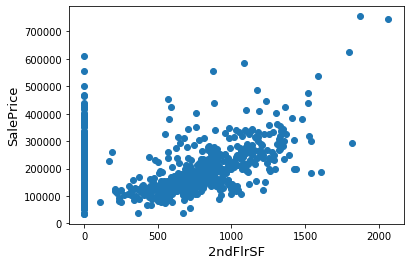

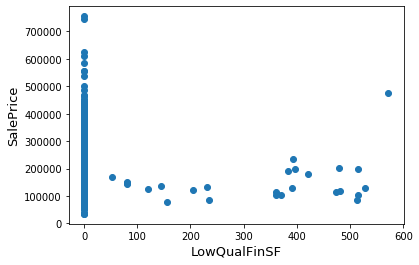

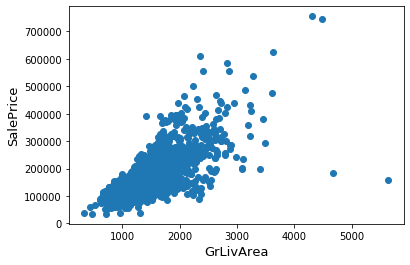

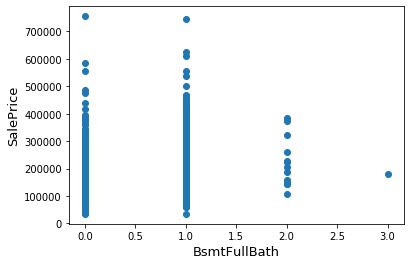

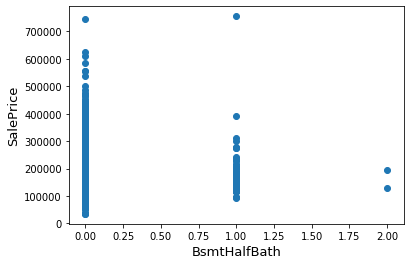

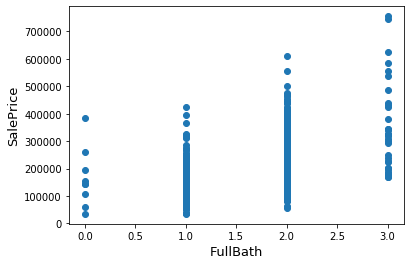

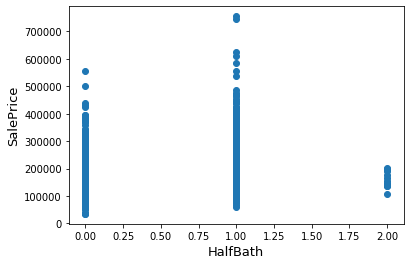

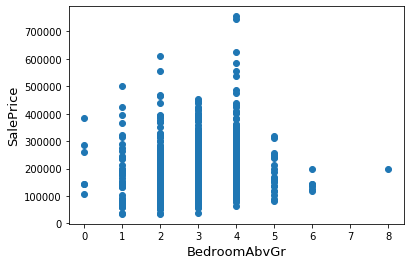

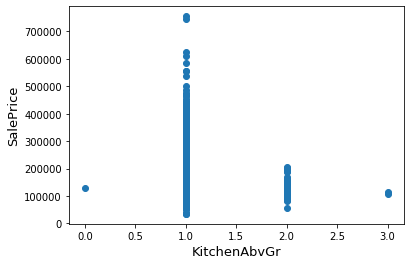

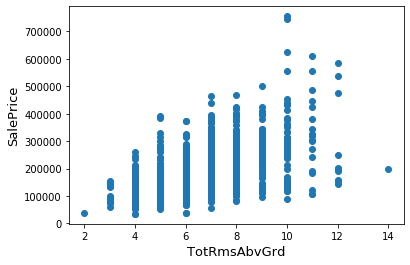

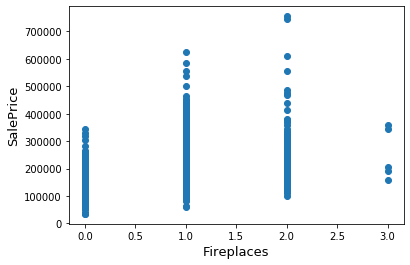

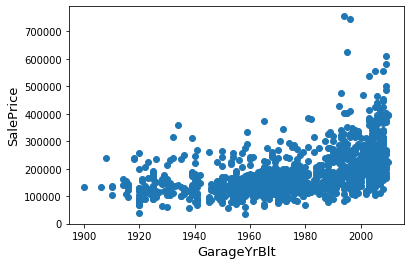

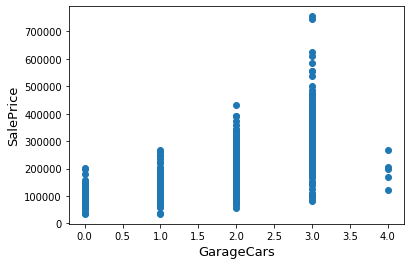

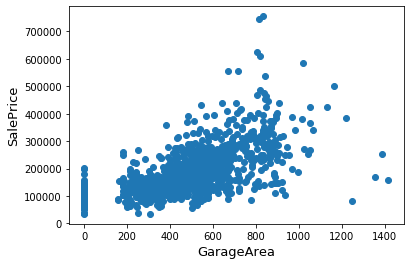

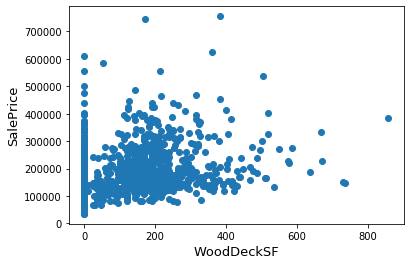

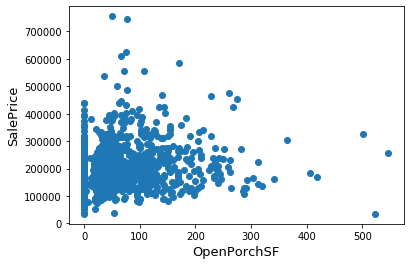

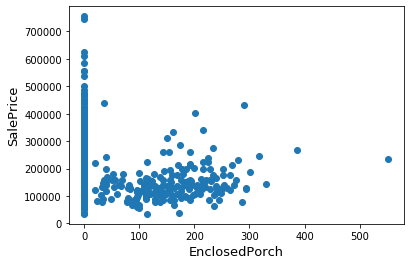

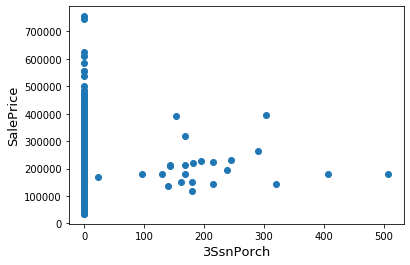

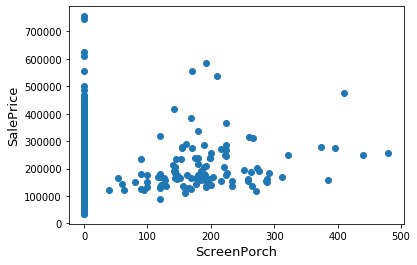

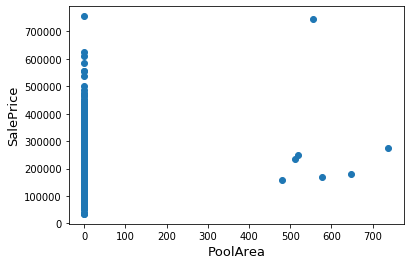

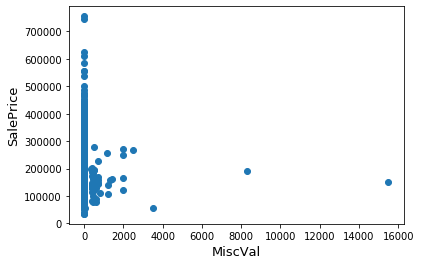

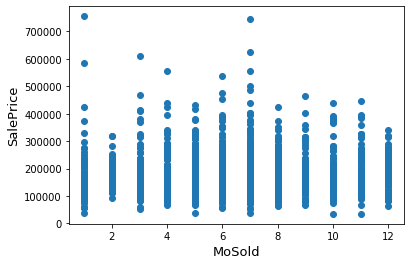

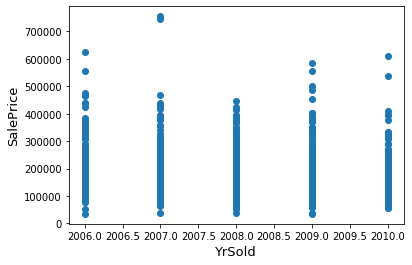

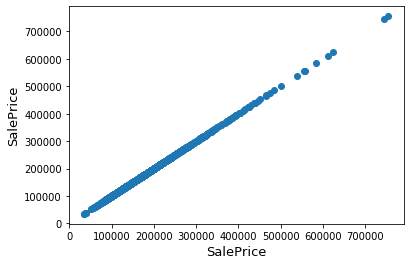

In [9]:
for col in  train.select_dtypes(exclude=object).columns:
    scatterPlot(train, col, "SalePrice")

In [10]:
# drop outliers detected visually
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index)


print(train.shape)

(1458, 80)


In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), sort = False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [14]:

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = all_data.select_dtypes(exclude=object) 
num_features_names = numeric_features.columns

# features that need a log transformation
log_features_names = ["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea", "OpenPorchSF"]

log_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', FunctionTransformer(np.log1p, validate=False)),
    ('logscaler', StandardScaler())])

#kbinDiscretizer features
year_features_names = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
year_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('kbd', KBinsDiscretizer(n_bins=5, encode='onehot-dense'))])

#numeric features that require a normal transformation

numeric_features_names = [x for x in num_features_names if x not in log_features_names + year_features_names]
print(len(numeric_features_names))

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features_names = all_data.select_dtypes(include=object).columns

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformers=[
        ('log', log_pipeline, log_features_names),
        ('num', numeric_pipeline, numeric_features_names),
        ('cat', cat_pipeline, categorical_features_names),
        ('year', year_pipeline, year_features_names)     
    ]

ct = ColumnTransformer(transformers=transformers)
Xt = ct.fit_transform(all_data)
print(Xt.shape)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', ct),
                      ('classifier', RandomForestRegressor(random_state=1, n_estimators = 500, criterion="mae"))
                     ])



27
(2917, 314)


c:\users\rajes\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [15]:
#fitting and prediction
train = Xt[:ntrain]
test = Xt[ntrain:]

elastic_net = ElasticNet(alpha = 0.2, l1_ratio = 0.9)
crossValidateModel(elastic_net, train, y_train, "elasticnet")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.3s


model elasticnet cross_val_score took 3.30218243598938 seconds
Scores: [17341.13741367 16900.89046821 16754.81211704 14834.98514011
 17551.54395819]
Mean: 16676.673819447424
standard deviation: 964.8943484596093


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [16]:
ridge_reg = Ridge(alpha = 0.1, solver="auto")
crossValidateModel(ridge_reg, train, y_train, "ridge")
lasso_reg = Lasso(alpha = 0.1)
crossValidateModel(lasso_reg, train, y_train, "lasso")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


model ridge cross_val_score took 4.0888965129852295 seconds
Scores: [17972.31395663 18564.16114916 17892.96096704 16228.16347291
 17810.41307247]
Mean: 17693.60252364176
standard deviation: 779.2884559652459


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.6s


model lasso cross_val_score took 6.2667412757873535 seconds
Scores: [18705.28118283 18428.45782162 18347.57614256 16942.89875127
 18165.30107619]
Mean: 18117.902994894062
standard deviation: 612.7134308096341


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


In [17]:
import AveragedModels as av
models = [elastic_net, ridge_reg, lasso_reg]
for x in models:
    print(x)
avmodel = av.AveragingModels(models)
crossValidateModel(avmodel, train, y_train, "average")

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=F

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


None
None
None
None
None


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s


TypeError: 'NoneType' object is not iterable

In [18]:
# try xgboost\n",
xgb_model = xgb.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                            learning_rate=0.05, max_depth=5,
                              min_child_weight=1.8, n_estimators=700,
                               reg_alpha=0.9, reg_lambda=0.9, gamma=0.01, 
                              silent=1, random_state =7, nthread = -1, refit = True)

crossValidateModel(xgb_model, train, y_train, "xgb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s


model xgb cross_val_score took 17.41548776626587 seconds
Scores: [14447.64901274 14364.19240957 16170.18469071 13239.37541613
 14508.49022766]
Mean: 14545.978351361331
standard deviation: 936.9501171380554


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


In [19]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                 learning_rate=0.05, n_estimators=720,
                                 max_bin = 55, bagging_fraction = 0.8,
                                 bagging_freq = 5, feature_fraction = 0.2319,
                                 feature_fraction_seed=9, bagging_seed=9,
                                 min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

crossValidateModel(model_lgb, train, y_train, "lightgbm", 1) # 1 job

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ............................... , score=-14487.937, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............................... , score=-15168.741, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ............................... , score=-15610.922, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] ............................... , score=-13008.543, total=   0.3s
[CV]  ................................................................
[CV] ............................... , score=-14566.535, total=   0.3s
model lightgbm cross_val_score took 1.627410888671875 seconds
Scores: [14487.93671237 15168.74137285 15610.92166282 13008.54302324
 14566.53471689]
Mean: 14568.535497634724
standard deviation: 881.6907278063406


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [20]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)

crossValidateModel(GBoost, train, y_train, "gboost")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.4s remaining:   32.1s


model gboost cross_val_score took 36.28411936759949 seconds
Scores: [14250.45344919 15313.42496598 15819.99050377 13665.1510268
 15755.61180063]
Mean: 14960.92634927529
standard deviation: 857.6219319719403


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.9s finished


In [24]:

adaboost_model = AdaBoostRegressor(base_estimator= elastic_net, random_state=5, n_estimators=1000)
crossValidateModel(adaboost_model, train, y_train, "adaboost")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s


model adaboost cross_val_score took 41.49758172035217 seconds
Scores: [24433.33653305 24407.01564689 22672.9867346  22110.73565864
 22579.14892797]
Mean: 23240.64470022732
standard deviation: 981.7781478733431


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished


In [26]:
averaged_models = av.AveragingModels(models = (GBoost, model_lgb, xgb_model))

averaged_models.fit(train, y_train)

#make predictions which we will submit. 
y_pred = averaged_models.predict(test)

#The lines below shows how to save predictions in format used for competition scoring
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': y_pred})
output.to_csv('../data/submission.csv', index=False)

(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False), LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=